In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Transform the data in the txt file into a dataframe

In [6]:
# Read the file into a list of lines
with open('wiki-RfA.txt', 'r') as file:
    lines = file.readlines()

# Create a list of dictionaries, where each dictionary represents a record
df = []
current_entry = {}

# Iterate through each line, current_entry = one log entry with all columns, df = list of all votee/voter pairs
for line in lines:
    line = line.strip()
    if line:
        key, value = line.split(':', 1)
        current_entry[key] = value
    else:
        df.append(current_entry)
        current_entry = {}

# Append  last record
if current_entry:
    df.append(current_entry)

# Convert into DataFrame and store in csv
df = pd.DataFrame(df)
df.columns = ['Source', 'Target', 'Vote', 'Results', 'Year', 'Date', 'Comment']
df


,Source,Target,Vote,Results,Year,Date,Comment
0,Steel1943,BDD,1,1,2013,"23:13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,"01:04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,"23:43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,"00:11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,"00:56, 20 April 2013","'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,"02:51, 2 Sep 2003",Support
198271,Angela,WhisperToMe,1,1,2003,"23:45, 26 Nov 2003",Support.
198272,Jiang,WhisperToMe,1,1,2003,,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,"05:38, 5 Dec 2003",Support. Age has nothing to do with maturity....


# Handle inconsistent data

In [7]:
# Set Nan values
# replace field that's entirely space (or empty) with NaN
df.replace(r'^\s*$', np.nan, regex=True, inplace=True)

# replace inconsistent date
df['Date'] = df['Date'].str.replace('Julu ', 'July ')
df['Date'] = df['Date'].str.replace('Janry ', 'January ')
df['Date'] = df['Date'].str.replace('Mya ', 'May ')
df['Date'] = df['Date'].str.replace('Jan ', 'January ')
df['Date'] = df['Date'].str.replace('Feb ', 'February ')
df['Date'] = df['Date'].str.replace('Mar ', 'March ')
df['Date'] = df['Date'].str.replace('Apr ', 'April ')
df['Date'] = df['Date'].str.replace('Jun ', 'June ')
df['Date'] = df['Date'].str.replace('Jul ', 'July ')
df['Date'] = df['Date'].str.replace('Aug ', 'August ')
df['Date'] = df['Date'].str.replace('Sep ', 'September ')
df['Date'] = df['Date'].str.replace('Oct ', 'October ')
df['Date'] = df['Date'].str.replace('Nov ', 'November ')
df['Date'] = df['Date'].str.replace('Dec ', 'December ')

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%H:%M, %d %B %Y', errors='coerce')

df

,Source,Target,Vote,Results,Year,Date,Comment
0,Steel1943,BDD,1,1,2013,2013-04-19 23:13:00,'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,2013,2013-04-20 01:04:00,'''Support''' as nominator.--
2,INeverCry,BDD,1,1,2013,2013-04-19 23:43:00,'''Support''' per noms.
3,Cncmaster,BDD,1,1,2013,2013-04-20 00:11:00,'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,2013,2013-04-20 00:56:00,"'''Support''', with great pleasure. I work wit..."
...,...,...,...,...,...,...,...
198270,172,Vancouverguy,1,1,2003,2003-09-02 02:51:00,Support
198271,Angela,WhisperToMe,1,1,2003,2003-11-26 23:45:00,Support.
198272,Jiang,WhisperToMe,1,1,2003,NaT,Support. --
198273,Pakaran,WhisperToMe,1,1,2003,2003-12-05 05:38:00,Support. Age has nothing to do with maturity....


# Store the dataframe in a csv file

In [8]:
df.to_csv('wiki-RfA.csv')

# Some global statistics and visualisation 

In [9]:
stats = df.describe(include='all')
stats.loc['perc_nan'] = (1 - stats.loc['count'] / len(df)) * 100
stats

,Source,Target,Vote,Results,Year,Date,Comment
count,196614,198275,198275,198275,198275,188907,191085
unique,10416,3497,3,2,11,NaN,163218
top,Siva1979,Everyking,1,1,2006,NaN,'''Support'''
freq,1232,987,144451,123288,45325,NaN,3456
mean,NaN,NaN,NaN,NaN,NaN,2008-01-23 01:07:40.444663296,NaN
min,NaN,NaN,NaN,NaN,NaN,2003-08-16 01:25:00,NaN
25%,NaN,NaN,NaN,NaN,NaN,2006-07-08 13:40:00,NaN
50%,NaN,NaN,NaN,NaN,NaN,2007-09-17 05:10:00,NaN
75%,NaN,NaN,NaN,NaN,NaN,2009-04-09 01:31:00,NaN
max,NaN,NaN,NaN,NaN,NaN,2013-06-05 19:50:00,NaN


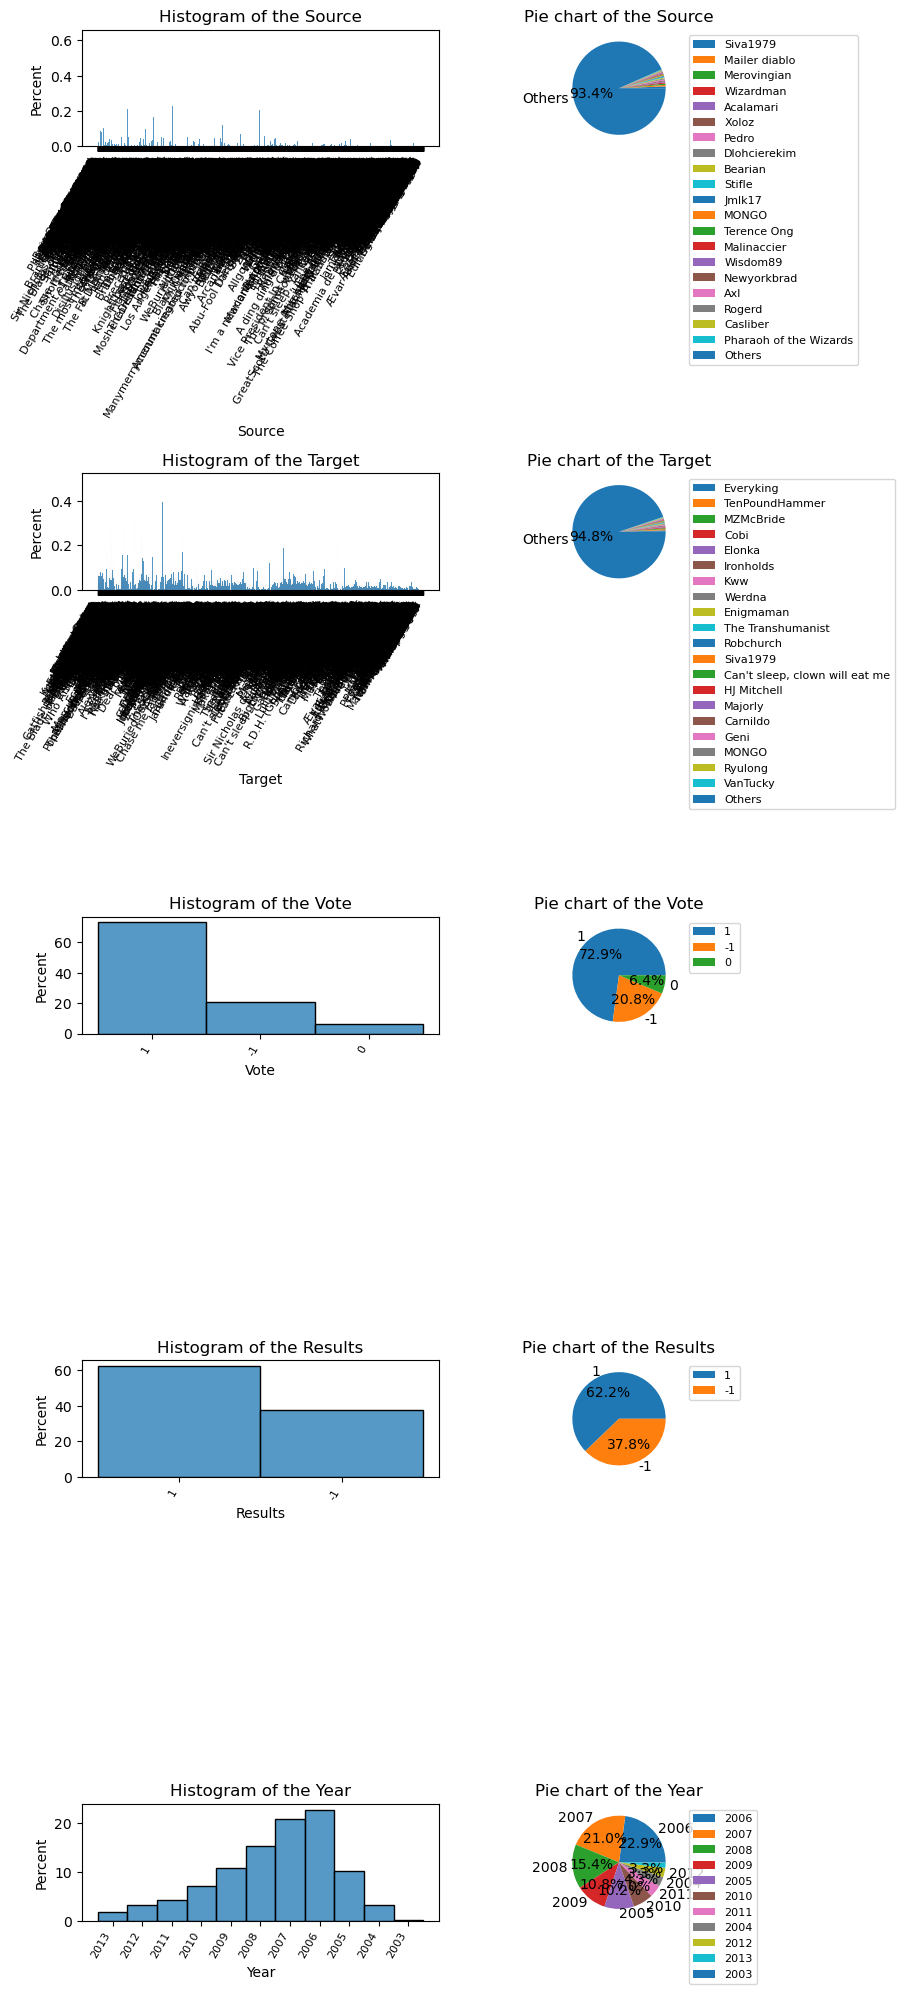

In [13]:
warnings.filterwarnings('ignore')
categorical_cols = ['Source', 'Target']
value_cols = ['Vote', 'Results', 'Year']
all_cols = categorical_cols + value_cols
n_top = 20
fig, axes = plt.subplots(len(all_cols), 2, figsize=(10,4*len(all_cols)))
for i, col in enumerate(all_cols):
    ax1 = axes[(2*i) // 2, (2*i) % 2]
    ax2 = axes[(2*i+1) // 2, (2*i+1) % 2]
    data = df[~df[col].isna()]
    if col in categorical_cols:
        top_n = pd.Series(data[col].value_counts().iloc[:n_top])
        others = pd.Series(data[col].value_counts().iloc[n_top:].sum(), index=['Others'])
        value_counts = pd.concat([top_n, others])
        
    elif col in value_cols:
        value_counts = data[col].value_counts()
        
    # Count plot
    chart = sns.histplot(data=data, x=col, ax=ax1, stat='percent', discrete=True) 
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='right', fontsize = 8)
    ax1.set_title('Histogram of the ' + col)
    
    # Pie chart
    val_counts = value_counts/np.sum(value_counts)
    labels = val_counts.index.to_list()

    wedges, texts, autotexts = ax2.pie(val_counts, labels = labels, autopct='%1.1f%%')
    threshold = 3
    for label, pct_label in zip(texts, autotexts):
        pct_value = pct_label.get_text().rstrip('%')
        if float(pct_value) < threshold:
            label.set_text('')
            pct_label.set_text('')
    
    ax2.legend(bbox_to_anchor=(1.05, 1), fontsize = 8)
    ax2.set_title('Pie chart of the ' + col)

fig.tight_layout()    
plt.show()